# Setup

## Importing Dependencies

In [1]:
import torch
from torchvision import transforms, utils
from PIL import Image
import math
import random
import os

import numpy as np
from torch import nn, autograd, optim
from torch.nn import functional as F
from tqdm import tqdm
import wandb

from copy import deepcopy

## Setting CUDNN benchmark to use pytorch

In [104]:
torch.backends.cudnn.benchmark = True

## Importing JoJoGAN modules (local file system)

In [3]:
import os
import sys
 
# directory
jojogan_dir = os.path.abspath("JoJoGAN/")
print(jojogan_dir)
sys.path.append(jojogan_dir)
print(sys.path)

/Users/ericli/Documents/CS_Courses/CSCI499/FaceStylizer/stylizer/JoJoGAN
['/Users/ericli/Documents/CS_Courses/CSCI499/FaceStylizer/stylizer', '/Users/ericli/anaconda3/envs/jjgan/lib/python38.zip', '/Users/ericli/anaconda3/envs/jjgan/lib/python3.8', '/Users/ericli/anaconda3/envs/jjgan/lib/python3.8/lib-dynload', '', '/Users/ericli/anaconda3/envs/jjgan/lib/python3.8/site-packages', '/Users/ericli/Documents/CS_Courses/CSCI499/FaceStylizer/stylizer/JoJoGAN']


In [4]:
print(sys.path)

['/Users/ericli/Documents/CS_Courses/CSCI499/FaceStylizer/stylizer', '/Users/ericli/anaconda3/envs/jjgan/lib/python38.zip', '/Users/ericli/anaconda3/envs/jjgan/lib/python3.8', '/Users/ericli/anaconda3/envs/jjgan/lib/python3.8/lib-dynload', '', '/Users/ericli/anaconda3/envs/jjgan/lib/python3.8/site-packages', '/Users/ericli/Documents/CS_Courses/CSCI499/FaceStylizer/stylizer/JoJoGAN']


In [5]:
from model import *
from e4e_projection import projection as e4e_projection
from util import *

## Creating Local Directories

In [6]:
os.makedirs('JoJoGAN/inversion_codes', exist_ok=True)
os.makedirs('JoJoGAN/style_images', exist_ok=True)
os.makedirs('JoJoGAN/style_images_aligned', exist_ok=True)
os.makedirs('JoJoGAN/models', exist_ok=True)

## Downloading 68 Shape Predictory DLIB Model to read faces from source images

In [7]:
# !curl http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 -o shape_predictor_68_face_landmarks.dat.bz2
# !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2
# !mv shape_predictor_68_face_landmarks.dat JoJoGAN/models/dlibshape_predictor_68_face_landmarks.dat

## JoJoGAN Prebuilt Model Key:Values

In [8]:
drive_ids = {
    "stylegan2-ffhq-config-f.pt": "1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK",
    "e4e_ffhq_encode.pt": "1o6ijA3PkcewZvwJJ73dJ0fxhndn0nnh7",
    "restyle_psp_ffhq_encode.pt": "1nbxCIVw9H3YnQsoIPykNEFwWJnHVHlVd",
    "arcane_caitlyn.pt": "1gOsDTiTPcENiFOrhmkkxJcTURykW1dRc",
    "arcane_caitlyn_preserve_color.pt": "1cUTyjU-q98P75a8THCaO545RTwpVV-aH",
    "arcane_jinx_preserve_color.pt": "1jElwHxaYPod5Itdy18izJk49K1nl4ney",
    "arcane_jinx.pt": "1quQ8vPjYpUiXM4k1_KIwP4EccOefPpG_",
    "arcane_multi_preserve_color.pt": "1enJgrC08NpWpx2XGBmLt1laimjpGCyfl",
    "arcane_multi.pt": "15V9s09sgaw-zhKp116VHigf5FowAy43f",
    "sketch_multi.pt": "1GdaeHGBGjBAFsWipTL0y-ssUiAqk8AxD",
    "disney.pt": "1zbE2upakFUAx8ximYnLofFwfT8MilqJA",
    "disney_preserve_color.pt": "1Bnh02DjfvN_Wm8c4JdOiNV4q9J7Z_tsi",
    "jojo.pt": "13cR2xjIBj8Ga5jMO7gtxzIJj2PDsBYK4",
    "jojo_preserve_color.pt": "1ZRwYLRytCEKi__eT2Zxv1IlV6BGVQ_K2",
    "jojo_yasuho.pt": "1grZT3Gz1DLzFoJchAmoj3LoM9ew9ROX_",
    "jojo_yasuho_preserve_color.pt": "1SKBu1h0iRNyeKBnya_3BBmLr4pkPeg_L",
    "art.pt": "1a0QDEHwXQ6hE_FcYEyNMuv5r5UnRQLKT",
}

In [47]:
# from StyelGAN-NADA
import gdown
print(jojogan_dir + "/models/")
class Downloader(object):
    def download_file(self, file_name):
        file_dst = os.path.join(jojogan_dir + "/models", file_name)
        file_id = "1_2cEpvD1mQyny4k2d5POadoCiFT7LaxK?usp=drive_link"
        if not os.path.exists(file_dst):
            print(f'Downloading {file_name}')
            gdown.download_folder("https://drive.google.com/drive/folders/host/1_2cEpvD1mQyny4k2d5POadoCiFT7LaxK?usp=drive_link", output=jojogan_dir + "/models")

/Users/ericli/Documents/CS_Courses/CSCI499/FaceStylizer/stylizer/JoJoGAN/models/


In [60]:
!gdown --no-cookies "https://drive.google.com/drive/folders/host/1_2cEpvD1mQyny4k2d5POadoCiFT7LaxK?usp=drive_link" 

gdown.download("https://drive.google.com/uc?id=1B7kPFX1TLKNCv2LBnsuRif7Bjap31HTC", output=jojogan_dir + "/models/") #disney preserve color
gdown.download("https://drive.google.com/uc?id=19PiGY1nLgxu3Bu0MzRBsUW-UhTAy9Dz8", output=jojogan_dir + "/models/") #dlib shape predictor
gdown.download("https://drive.google.com/uc?id=1O_4VW3Pp7lL_iQmlTCtU6KIJay-7xPtZ", output=jojogan_dir + "/models/") #e4e_ffhq_encode.pt
gdown.download("https://drive.google.com/uc?id=14fJFJqELahG-R2gty6Rc0BRXWjXwChwT", output=jojogan_dir + "/models/") #stylegan2-ffhq-config-f.pt

Downloading...
From (original): https://drive.google.com/uc?id=1B7kPFX1TLKNCv2LBnsuRif7Bjap31HTC
From (redirected): https://drive.usercontent.google.com/download?id=1B7kPFX1TLKNCv2LBnsuRif7Bjap31HTC&confirm=t&uuid=01e1e8ad-fa29-4559-9fa8-6904d4509105
To: /Users/ericli/Documents/CS_Courses/CSCI499/FaceStylizer/stylizer/JoJoGAN/models/disney_preserve_color.pt

  0%|                                                                                                                        | 0.00/133M [00:00<?, ?B/s]
  0%|▍                                                                                                               | 524k/133M [00:00<01:01, 2.15MB/s]
  1%|▉                                                                                                              | 1.05M/133M [00:00<00:51, 2.54MB/s]
  1%|█▎                                                                                                             | 1.57M/133M [00:00<00:43, 3.05MB/s]
  2%|█▊                    

'/Users/ericli/Documents/CS_Courses/CSCI499/FaceStylizer/stylizer/JoJoGAN/models/stylegan2-ffhq-config-f.pt'

In [61]:
!ls JoJoGAN/models/

disney_preserve_color.pt
dlibshape_predictor_68_face_landmarks.dat
e4e_ffhq_encode.pt
stylegan2-ffhq-config-f.pt


## Use CUDA on device for pytorch

In [10]:
device = 'cpu'

# Load Pretrained StyleGAN

In [11]:
latent_dim = 512

# Load original generator
original_generator = Generator(1024, latent_dim, 8, 2).to(device)
ckpt = torch.load('JoJoGAN/models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
original_generator.load_state_dict(ckpt["g_ema"], strict=False)
mean_latent = original_generator.mean_latent(10000)

# to be finetuned generator
generator = deepcopy(original_generator)

transform = transforms.Compose(
    [
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [12]:
!ls

JoJoGAN/         environment.yml  stylizer.ipynb


# Setup Source Image

Loading e4e over the pSp framework from checkpoint: JoJoGAN/models/e4e_ffhq_encode.pt


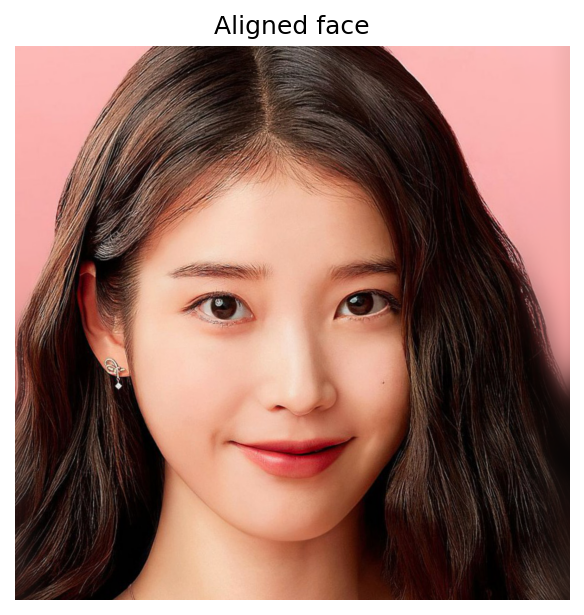

In [13]:
plt.rcParams['figure.dpi'] = 150

filename = 'iu.jpeg'
filepath = f'JoJoGAN/test_input/{filename}'

# uploaded = files.upload()
# filepath = list(uploaded.keys())[0]
name = strip_path_extension(filepath)+'.pt'

# aligns and crops face from the source image
aligned_face = align_face(filepath)

# my_w = restyle_projection(aligned_face, name, device, n_iters=1).unsqueeze(0)
my_w = e4e_projection(aligned_face, name, device).unsqueeze(0)

%matplotlib inline
display_image(aligned_face, title='Aligned face')

## Choose Pretrained Model

In [14]:
plt.rcParams['figure.dpi'] = 150
pretrained = 'disney' #@param ['art', 'arcane_multi', 'sketch_multi', 'arcane_jinx', 'arcane_caitlyn', 'jojo_yasuho', 'jojo', 'disney']
#@markdown Preserve color tries to preserve color of original image by limiting family of allowable transformations. Otherwise, the stylized image will inherit the colors of the reference images, leading to heavier stylizations.
preserve_color = True #@param{type:"boolean"}

if preserve_color:
    ckpt = f'{pretrained}_preserve_color.pt'
else:
    ckpt = f'{pretrained}.pt'

#@title Generate results
n_sample =  5#@param {type:"number"}
seed = 3000 #@param {type:"number"}

In [15]:
!ls -lah JoJoGAN/models/

total 3549472
drwxr-xr-x   6 ericli  staff   192B Mar 13 19:27 ./
drwxr-xr-x  19 ericli  staff   608B Mar 13 20:20 ../
-rw-r--r--@  1 ericli  staff   127M Mar 12 16:38 disney_preserve_color.pt
-rw-r--r--   1 ericli  staff    95M Mar 13 19:23 dlibshape_predictor_68_face_landmarks.dat
-rw-r--r--@  1 ericli  staff   1.1G Mar 12 16:12 e4e_ffhq_encode.pt
-rw-r--r--@  1 ericli  staff   364M Mar 12 16:09 stylegan2-ffhq-config-f.pt


### Load checkpoint

In [16]:
ckpt = torch.load(os.path.join('JoJoGAN/models', ckpt), map_location=lambda storage, loc: storage)
generator.load_state_dict(ckpt["g"], strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['conv1.conv.update', 'to_rgb1.conv.update', 'convs.0.conv.update', 'convs.1.conv.update', 'convs.2.conv.update', 'convs.3.conv.update', 'convs.4.conv.update', 'convs.5.conv.update', 'convs.6.conv.update', 'convs.7.conv.update', 'convs.8.conv.update', 'convs.9.conv.update', 'convs.10.conv.update', 'convs.11.conv.update', 'convs.12.conv.update', 'convs.13.conv.update', 'convs.14.conv.update', 'convs.15.conv.update', 'to_rgbs.0.conv.update', 'to_rgbs.1.conv.update', 'to_rgbs.2.conv.update', 'to_rgbs.3.conv.update', 'to_rgbs.4.conv.update', 'to_rgbs.5.conv.update', 'to_rgbs.6.conv.update', 'to_rgbs.7.conv.update'])

### Train checkpointed generator on test sample

In [17]:
torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    z = torch.randn(n_sample, latent_dim, device=device)

    original_sample = original_generator([z], truncation=0.7, truncation_latent=mean_latent)
    sample = generator([z], truncation=0.7, truncation_latent=mean_latent)

    original_my_sample = original_generator(my_w, input_is_latent=True)
    my_sample = generator(my_w, input_is_latent=True)

In [18]:
# display reference images
if pretrained == 'arcane_multi':
    style_path = f'JoJoGAN/style_images_aligned/arcane_jinx.png'
elif pretrained == 'sketch_multi':
    style_path = f'JoJoGAN/style_images_aligned/sketch.png'
else:
    style_path = f'JoJoGAN/style_images_aligned/{pretrained}.png'

In [19]:
style_image = transform(Image.open(style_path)).unsqueeze(0).to(device)
face = transform(aligned_face).unsqueeze(0).to(device)

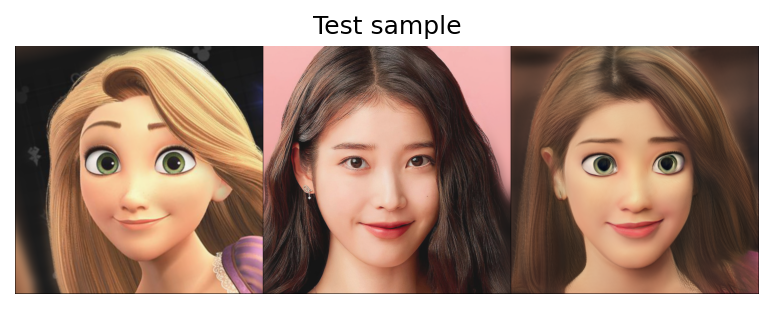

In [20]:
my_output = torch.cat([style_image, face, my_sample], 0)
%matplotlib inline
display_image(utils.make_grid(my_output, normalize=True, nrow=3), title='Test sample')

In [103]:
print(my_output.shape)
tmp = utils.make_grid(my_output, normalize=True, nrow=3)
print(tmp.shape)

image = tmp.permute(1, 2, 0).detach().numpy()

# Reshape numpy arrays for PIL
array = np.reshape(image, (1028, 3080, 3)) 
array = (255 * array).astype(np.uint8)

# Save image
img = Image.fromarray(array, 'RGB')
img.save("123.jpg")


torch.Size([3, 3, 1024, 1024])
torch.Size([3, 1028, 3080])
